In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [4]:
import random

class Neuron:
    
    def __init__(self, nin):
#### my add ##########################################        
        # random.seed(12345)  # WARNING: all neurons will have the same weights and bias
######################################################        
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

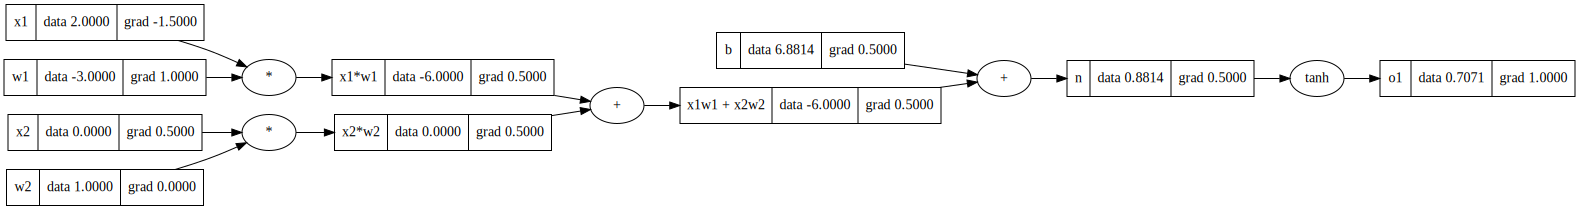

In [55]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o1 = n.tanh(); o1.label = 'o1'
o1.backward()
o1_grad = x1.grad  # store x1.grad, more calculation with x1 will reset x1.grad to zero
draw_dot(o1)

In [52]:
h = 0.0001
x1 += h  # increment x1 by h

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o2 = n.tanh(); o2.label = 'o2'
o_grad = (o2 - o1) / h 

print(f'calculation of derivative of "o" with respect to "x1" = {o_grad.data}')
print(f'o2: {o.data}, o1: {o1.data}, o2-o1: {o2.data-o1.data}, h: {h}')

#### Neural Network MLP(3, [4, 4, 1])
* input layer - 3 nodes
* hidden layer 1 - 4 nodes
* hidden layer 2 - 4 nodes
* output layer - 2 nodes

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

In [5]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

In [6]:
# number of parameters (e.g sum (weights + bias to each neuron))
print(f'len(n.parameters()): {len(n.parameters())}')
n.parameters()

len(n.parameters()): 41


[Value(data = 0.8735929368001456),
 Value(data = -0.5138530211711041),
 Value(data = 0.39263108152759263),
 Value(data = -0.14072333806887238),
 Value(data = 0.2897097604681296),
 Value(data = -0.5370433592427473),
 Value(data = 0.058772149040092314),
 Value(data = 0.32367739552314534),
 Value(data = 0.5083631386487744),
 Value(data = -0.48509682723714387),
 Value(data = -0.8327317873276883),
 Value(data = 0.6158606674980869),
 Value(data = 0.7273299694070476),
 Value(data = 0.8278672867741526),
 Value(data = 0.3367504489221185),
 Value(data = 0.8407916689255228),
 Value(data = -0.4882617627567254),
 Value(data = -0.2307859447893139),
 Value(data = 0.21710460159349432),
 Value(data = 0.7741193900189551),
 Value(data = 0.36748102030695096),
 Value(data = 0.1228881289439463),
 Value(data = -0.22774155292134446),
 Value(data = 0.39493683385364897),
 Value(data = -0.005813456818641871),
 Value(data = -0.6696635742164365),
 Value(data = 0.5057299527869183),
 Value(data = 0.15172557207969462

#### ---- Start: Manual calculation of a forward pass ----

##### Transpose inputs xs

In [7]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get neural network's weights and biases matrices

In [8]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}')
        print(f'b_mat:  {b_mat}')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('----')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
neuron 0
w0:  0.8735929,   w0.grad:  0.0000000
w1: -0.5138530,   w1.grad:  0.0000000
w2:  0.3926311,   w2.grad:  0.0000000
b:  -0.1407233
b_mat:  [-0.14072333806887238]
neuron 1
w0:  0.2897098,   w0.grad:  0.0000000
w1: -0.5370434,   w1.grad:  0.0000000
w2:  0.0587721,   w2.grad:  0.0000000
b:   0.3236774
b_mat:  [-0.14072333806887238, 0.32367739552314534]
neuron 2
w0:  0.5083631,   w0.grad:  0.0000000
w1: -0.4850968,   w1.grad:  0.0000000
w2: -0.8327318,   w2.grad:  0.0000000
b:   0.6158607
b_mat:  [-0.14072333806887238, 0.32367739552314534, 0.6158606674980869]
neuron 3
w0:  0.7273300,   w0.grad:  0.0000000
w1:  0.8278673,   w1.grad:  0.0000000
w2:  0.3367504,   w2.grad:  0.0000000
b:   0.8407917
b_mat:  [-0.14072333806887238, 0.32367739552314534, 0.6158606674980869, 0.8407916689255228]
----
layer: 1, neuron_cnt: 4
----
neuron 0
w0: -0.4882618,   w0.grad:  0.0000000
w1: -0.2307859,   w1.grad:  0.0000000
w2:  0.2171046,   w2.grad:  0.0000000
w

In [9]:
print(f'type(w_mats): {type(w_mats)}')
print(f'type(w_mats[0]): {type(w_mats[0])}')
print(f'w_mats[0].shape: {w_mats[0].shape}')
print(f'w_mats[0]: {w_mats[0]}\n')
print(f'type(xs_mats): {type(xs_mats)}')
print(f'type(xs_mats[0]): {type(xs_mats[0])}')
print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats[0]: {xs_mats[0]}\n')
print(f'type(b_mats): {type(b_mats)}')
print(f'type(b_mats[0]): {type(b_mats[0])}')
print(f'b_mats[0].shape: {b_mats[0].shape}')
print(f'b_mats[0]: {b_mats[0]}\n')

type(w_mats): <class 'list'>
type(w_mats[0]): <class 'numpy.ndarray'>
w_mats[0].shape: (4, 3)
w_mats[0]: [[ 0.87359294 -0.51385302  0.39263108]
 [ 0.28970976 -0.53704336  0.05877215]
 [ 0.50836314 -0.48509683 -0.83273179]
 [ 0.72732997  0.82786729  0.33675045]]

type(xs_mats): <class 'list'>
type(xs_mats[0]): <class 'numpy.ndarray'>
xs_mats[0].shape: (2, 3)
xs_mats[0]: [[ 2.   3.  -1. ]
 [ 3.  -1.   0.5]]

type(b_mats): <class 'list'>
type(b_mats[0]): <class 'numpy.ndarray'>
b_mats[0].shape: (1, 4)
b_mats[0]: [[-0.14072334  0.3236774   0.61586067  0.84079167]]



##### Calculation for a forward pass

<img src="..\karpathy\img\neural_mat.PNG">

In [10]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])
  output = np.tanh(np.matmul(weights, input) + bias)

  if verbose:
    print(f'layer: {layer}')
    print(f'weights:\n{weights}\n')
    # print(f'xs_mats_T[layer]:\n{xs_mats_T[layer]}\n')
    print(f'input:\n{input}\n')    
    print(f'bias:\n{bias}\n')
    print(f'output:\n{output}\n')    

yout = output[0]
ys = ys
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')

layer: 0
weights:
[[ 0.87359294 -0.51385302  0.39263108]
 [ 0.28970976 -0.53704336  0.05877215]
 [ 0.50836314 -0.48509683 -0.83273179]
 [ 0.72732997  0.82786729  0.33675045]]

input:
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

bias:
[[-0.14072334]
 [ 0.3236774 ]
 [ 0.61586067]
 [ 0.84079167]]

output:
[[-0.31647746  0.996617  ]
 [-0.64506795  0.94241763]
 [ 0.7657737   0.97620274]
 [ 0.99972303  0.98244207]]

layer: 1
weights:
[[-0.48826176 -0.23078594  0.2171046   0.77411939]
 [ 0.12288813 -0.22774155  0.39493683 -0.00581346]
 [ 0.50572995  0.15172557 -0.02029647 -0.07911027]
 [-0.40368154 -0.98412607 -0.41896412 -0.26796684]]

input:
[[-0.31647746  0.996617  ]
 [-0.64506795  0.94241763]
 [ 0.7657737   0.97620274]
 [ 0.99972303  0.98244207]]

bias:
[[ 0.36748102]
 [-0.66966357]
 [ 0.07058051]
 [-0.56927988]]

output:
[[ 0.9233129   0.56206031]
 [-0.25899022 -0.36443598]
 [-0.27473272  0.55116542]
 [-0.37602325 -0.98838313]]

layer: 2
weights:
[[-0.46880079 -0.41514718  0.76062341  0.6606

#### ---- End: Manual calculation of a forward pass ----

#### Micrograd results are same as manual calculation

In [11]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.07524534874752317, 0.4716381575944757]
ys:                 [1.0, -1.0]
loss_data:          3.0208900319011525


In [12]:
# initialize
# step = 0

In [13]:
learning_rate = 0.05

for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.07524534874752317), Value(data = 0.4716381575944757)]
step: 0, loss: 3.0208900319011525
-------
ypred: [Value(data = 0.3526632368820801), Value(data = 0.18401509731242097)]
step: 1, loss: 1.8209366355477277
-------
ypred: [Value(data = 0.4842863206807364), Value(data = -0.23972712384692885)]
step: 2, loss: 0.8439754452510753
-------
ypred: [Value(data = 0.6264590762729584), Value(data = -0.4794114590371637)]
step: 3, loss: 0.4105452506806663
-------
ypred: [Value(data = 0.7049421444361733), Value(data = -0.5951730017611762)]
step: 4, loss: 0.2509440366329807
-------
ypred: [Value(data = 0.7503355682406776), Value(data = -0.6617128058003595)]
step: 5, loss: 0.17677055424517063
-------
ypred: [Value(data = 0.7802125459665725), Value(data = -0.7052332199344794)]
step: 6, loss: 0.135193979580691
-------
ypred: [Value(data = 0.801615094994701), Value(data = -0.7362477144889771)]
step: 7, loss: 0.10892183864624967
-------
ypred: [Value(data = 0.8178587074698459), Value

In [14]:
learning_rate = 0.05

# Create a list of losses
losses = []
for k in range(800):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.9679304168797546), Value(data = -0.9631575959210988)]
step: 0, loss: 0.0023858208998193634
-------
ypred: [Value(data = 0.9680124767955376), Value(data = -0.9632563673995103)]
step: 1, loss: 0.0023732961774357935
-------
ypred: [Value(data = 0.968093918602189), Value(data = -0.9633543748292893)]
step: 2, loss: 0.002360899874315968
-------
ypred: [Value(data = 0.9681747499906904), Value(data = -0.9634516279110539)]
step: 3, loss: 0.0023486300405071154
-------
ypred: [Value(data = 0.9682549785188951), Value(data = -0.9635481361747257)]
step: 4, loss: 0.0023364847651721555
-------
ypred: [Value(data = 0.9683346116144735), Value(data = -0.9636439089833628)]
step: 5, loss: 0.0023244621756162397
-------
ypred: [Value(data = 0.9684136565777816), Value(data = -0.9637389555368867)]
step: 6, loss: 0.002312560436342201
-------
ypred: [Value(data = 0.9684921205846508), Value(data = -0.9638332848757053)]
step: 7, loss: 0.0023007777481340707
-------
ypred: [Value(data = 0.9685

Text(0, 0.5, 'Loss')

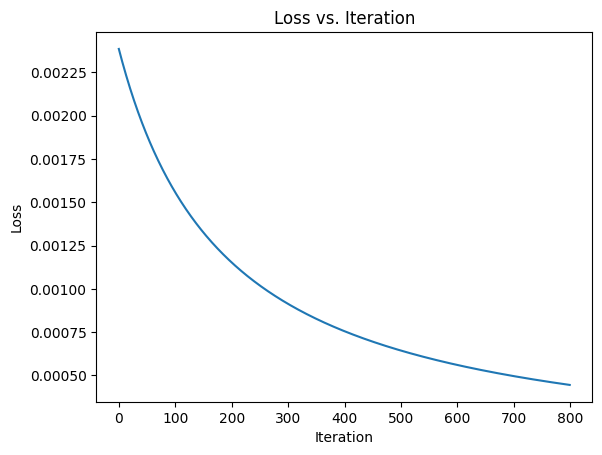

In [15]:

# Create a list of iterations
iterations = range(len(losses))

# Plot the loss as a function of iteration
plt.plot(iterations, losses)

# Add a title to the plot
plt.title('Loss vs. Iteration')

# Add labels to the x-axis and y-axis
plt.xlabel('Iteration')
plt.ylabel('Loss')

# TODO add derivative, add draw_dot, backward

#### Tanh activation function

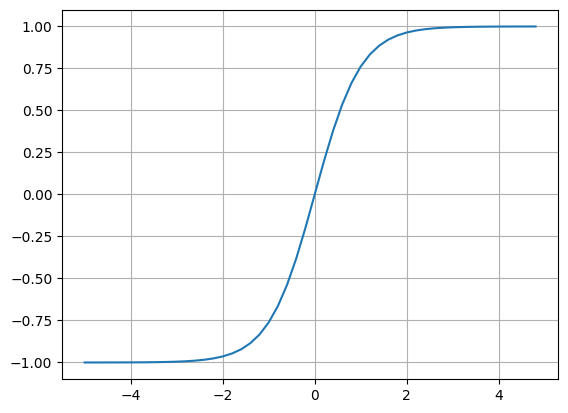

In [16]:
_num = np.arange(-5, 5, 0.2)
plt.plot(_num, np.tanh(_num))
plt.grid()